## 대략적인 틀

Mel-Frequency Cepstral Coefficients (MFCCs)기술

Neural Network 기반 피처 추출 방식 (deterministic)이랑 다름.

1. Audio Siganl을 짧은 구간으로 여러개 나눈다 (25ms 내외) 이렇게 나누어진 음성을 프레임(frame)이라고 한다.

2. 프레임을 각각 Fourier Transform 해준다. -> 음성의 주파수 정보를 추출한다. 여기서 푸리에 변환을 시켜준 프레임을 스펙트럼(spectrum)이라고 함

3. 여기서 말소리에 범위에 속하는 주파수 영역대를 제외하고는 Noise를 지워준다. 여기서 필터를 Mel Filter Bank라고 함. 그리고 이렇게 지워진 녀석을 Mel Spectrum이라고 함

4. 여기에 로그를 취해주어 log-Mel Spectrum을 만든다 -> 로그 멜 스펙트럼에 Inverse Fourier Transform을 해준다. 

5. 역 푸리에전환으로 Frequency domain을 Time domain으로 바꾸어준다.

+) MFCC는 기존 음성 인식 시스템에 가우시안 믹스처 모델 입력으로 측정된다.

In [1]:
import scipy.io.wavfile
import numpy as np
from scipy.fftpack import dct

In [2]:
sample_rate, signal =  scipy.io.wavfile.read('example.wav')
sample_rate, signal

(16000, array([36, 37, 60, ...,  7,  9,  8], dtype=int16))

sample_rate = 16000kHz, signal = int16

In [3]:
len(signal)

183280

In [4]:
len(signal)/sample_rate

11.455

In [5]:
cutsignal = signal[0:int(3.5*sample_rate)]
len(cutsignal)

56000

## Preemphasis

사람의 말소리는 일반적으로 Low frequency energy가 high frequency 보다 많다 그래서 high frequency를 올려주어 음성 인식 accuracy를 높인다.

yt= xt−αxt−1 (α = preemphasis coefficient)

In [20]:
pre_emphasis = 0.97 # 보통 0.95~0.97
emphasized_signal = np.append(cutsignal[0], cutsignal[1:] - pre_emphasis * cutsignal[:-1])
emphasized_signal

array([  36.  ,    2.08,   24.11, ..., -233.76, -262.5 ,  -61.87])

## Framing

음성 신호를 아주 짧은 시간 단위로 잘게 쪼개어 준다 ( 푸리에 변환을 하여 주파수별 정보를 얻기 위해) (non-stationary -> stationary)

11초짜리 -> 3.5초로 짜르고 -> 원시 신호를 아주 짧게 자른다

In [21]:
frame_size = 0.025 # 잘개 쪼개어지는 구간
frame_stride = 0.01  # 겹치는 구간
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))
pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z)
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + \
          np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]

In [26]:
pad_signal, len(pad_signal), len(cutsignal)

((348, 400), (348, 400))

In [27]:
indices.shape, frames.shape

((348, 400), (348, 400))

In [30]:
frames, indices

(array([[  36.  ,    2.08,   24.11, ...,    4.56,    3.74,    2.89],
        [  16.43,  -32.15,  -47.2 , ...,  -13.06,  -16.45,    2.07],
        [  -9.  ,   -9.27,   11.46, ...,   -5.09,   -7.24,   -2.45],
        ...,
        [ 315.7 ,  130.65,  211.81, ..., -121.15,  -17.69, -195.02],
        [ 283.62, 1098.42,  815.34, ...,   20.53,  136.92,  150.79],
        [ -59.03, -212.81, -289.18, ..., -157.35,  -81.12,   24.54]]),
 array([[    0,     1,     2, ...,   397,   398,   399],
        [  160,   161,   162, ...,   557,   558,   559],
        [  320,   321,   322, ...,   717,   718,   719],
        ...,
        [55200, 55201, 55202, ..., 55597, 55598, 55599],
        [55360, 55361, 55362, ..., 55757, 55758, 55759],
        [55520, 55521, 55522, ..., 55917, 55918, 55919]]))

emphasized_signal에 zero_padding해준게 pad_signal
indice는 index기준으로 값을 보려고. 앞 프레임 0 ~ 399, 뒤프레임 160 ~ 559로 겹치는걸 확인할 수 있다

## Windowing

프레임에 특정 함수를 넣어서 경계를 스무스하게 만든다. 대표적으로 Hamming Window라는 함수 사용.

양 끝이 상수값이었다가 잘려서 0이 되기때문에 그곳을 스무스하게

여기 코드가 이해가 잘 안감

In [32]:
frames *= np.array([0.54 - 0.46 * np.cos((2 * np.pi * n) / (frame_length - 1)) for n in range(frame_length)])
frames

array([[ 0.2304    ,  0.01333099,  0.15518526, ...,  0.02935067,
         0.02397014,  0.018496  ],
       [ 0.105152  , -0.20605349, -0.30380523, ..., -0.08406136,
        -0.10543017,  0.013248  ],
       [-0.0576    , -0.05941262,  0.07376288, ..., -0.03276205,
        -0.04640209, -0.01568   ],
       ...,
       [ 2.02048   ,  0.83735266,  1.36332596, ..., -0.77978821,
        -0.11337749, -1.248128  ],
       [ 1.815168  ,  7.03991512,  5.24797786, ...,  0.1321424 ,
         0.8775379 ,  0.965056  ],
       [-0.377792  , -1.36392667, -1.86132195, ..., -1.01279137,
        -0.51990852,  0.157056  ]])

## Fourier Transform

고속 푸리에 변환 기법 사용 (np.fft.fft)

NFFT -> 몇 개의 구간(bin)으로 분석할지 나타내는 인자. 보통 256,512

In [62]:
NFFT = 512
dft_frames = np.fft.rfft(frames,NFFT)
dft_frames
# np.fft.rfft와 np.fft.rfft 중 무엇을 쓰던지 계산 결과가 달라지지 않음.
# 하지만 계산량을 줄이려면 rfft를 쓰는 것이 이득. 더 알아보기

array([[  48.34207625+0.00000000e+00j,  -26.42495684-6.49920760e+01j,
         -19.35232241+7.87681117e+01j, ...,
         -25.53478812-2.68643025e+00j,   -1.19394688+2.32291308e+01j,
          23.20132091+0.00000000e+00j],
       [-136.92139281+0.00000000e+00j,   83.32137111+9.54621323e+01j,
           9.70135027-9.08543573e+01j, ...,
          -9.14375956+9.33657150e-01j,    6.81515127-1.34643818e-01j,
          -5.22421484+0.00000000e+00j],
       [   6.57319106+0.00000000e+00j,   -4.423272  -2.48764564e+01j,
         -33.89939497+4.27430654e+01j, ...,
          -7.11349679-1.39538781e+01j,   -7.53909601+9.14066240e+00j,
          10.76428285+0.00000000e+00j],
       ...,
       [  87.04593332+0.00000000e+00j,  -76.31689303-7.55580453e+01j,
           0.47465627+1.03793891e+02j, ...,
          -9.45409371-1.74493839e+02j, -119.7415913 +4.99944334e+01j,
         129.25488261+0.00000000e+00j],
       [ -22.06181655+0.00000000e+00j,   44.98353263+3.03926260e+01j,
          26.76516102-

## Magnitude

이산 푸리에 변환 값은 복소수 값으로 실수부와 허수부 존재.

X[k]=a+b×j 여기서 진폭은 √a2+b2, 위상은 arctan(b/a)가 된다

음성 인식에 불필요한 위상 정보를 없애주고 진폭만 남겨주는 코드

In [45]:
mag_frames = np.absolute(dft_frames)
mag_frames

array([[ 48.34207625,  70.15873631,  81.11058993, ...,  25.67571444,
         23.25979419,  23.20132091],
       [136.92139281, 126.7101795 ,  91.3708402 , ...,   9.19130321,
          6.81648118,   5.22421484],
       [  6.57319106,  25.26664635,  54.55399731, ...,  15.66245676,
         11.84861501,  10.76428285],
       ...,
       [ 87.04593332, 107.39313931, 103.79497672, ..., 174.7497628 ,
        129.75936212, 129.25488261],
       [ 22.06181655,  54.28839583,  33.61433419, ..., 665.30854746,
        391.79025626, 200.80679868],
       [ 98.60182418,  96.96451112,  72.58200422, ..., 255.73245345,
        164.75070582,  50.02624269]])

## Power Spectrum

k번째 이산 푸리에 변환 결과 = X[k]인데, 파워를 구하는 공식 (? ㅠㅠ)

In [46]:
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))
pow_frames

array([[4.56436784e+00, 9.61376617e+00, 1.28494684e+01, ...,
        1.28758264e+00, 1.05667583e+00, 1.05136971e+00],
       [3.66161481e+01, 3.13583390e+01, 1.63059188e+01, ...,
        1.65000107e-01, 9.07508120e-02, 5.33055091e-02],
       [8.43883608e-02, 1.24688168e+00, 5.81277075e+00, ...,
        4.79126078e-01, 2.74198589e-01, 2.26308174e-01],
       ...,
       [1.47988174e+01, 2.25259499e+01, 2.10417914e+01, ...,
        5.96435148e+01, 3.28857267e+01, 3.26305170e+01],
       [9.50632323e-01, 5.75630844e+00, 2.20688176e+00, ...,
        8.64522389e+02, 2.99803916e+02, 7.87565828e+01],
       [1.89889057e+01, 1.83635086e+01, 1.02893503e+01, ...,
        1.27732593e+02, 5.30132716e+01, 4.88793937e+00]])

## Filter Banks

고주파수 영역대 대비 저주파수 영역대를 보는 방법. 왜냐하면 저주파수 영역대가 고주파수 대비 민감하기 때문이다. 사용하는 필터뱅크는 멜 스케일(Mel Scale) 필터

In [48]:
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / sample_rate)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right
    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

nfilt = 멜 스케일 필터

fbank[0] = 헤르츠 기준 저주파수 영역대를 세밀하게 살피는 필터

fbank[39] = 고주파수 영역대를 넓게 보는 필터

In [54]:
filter_banks = np.dot(pow_frames, fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
# 두번째 줄 -> 결과가 0인곳에 아주 작은 숫자를 더해서 numerical problem 예방

## Log-Mel Spectrum

사람의 목소리 인식은 로그 스케일에 더 가깝다고 함. 로그 취해줌

In [55]:
filter_banks = 20 * np.log10(filter_banks)

In [61]:
filter_banks

array([[19.6578711 , 24.08243444, 13.28362604, ..., 37.41129385,
        35.12449152, 43.85294179],
       [29.92706103, 25.02887464,  4.56447493, ..., 29.99648702,
        27.63755602, 31.12405847],
       [ 1.91650485, 20.62599882, 27.84652515, ..., 33.67880595,
        33.86877509, 35.21519583],
       ...,
       [27.05366229, 35.49493867, 80.35178791, ..., 82.34780355,
        60.26241633, 71.50671916],
       [15.20288113, 33.00403036, 80.75428113, ..., 76.87788039,
        71.14996413, 82.2580797 ],
       [25.27911327, 34.40468846, 80.88589194, ..., 85.26351843,
        67.78637171, 74.19285132]])

In [63]:
from scipy.fftpack import dct
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

## MFCCs

로그 멜 스펙트럼에 역푸리에 변환을 해주어 변수 간 상관관계를 해소한 것.

최근 딥러닝 기반 모델에서는 MFCC보다는 로그 멜 스펙트럼이 더 널리 쓰이는 듯 함

In [64]:
from scipy.fftpack import dct
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13

In [65]:
mfcc

array([[-69.3685124 , -73.11219282,   5.67513949, ...,  -1.16277698,
          0.65669277,  -3.93879587],
       [-52.33524779, -66.52306496,   9.53491011, ...,   8.42687174,
         -0.67383872,  16.95492264],
       [-47.45887971, -61.18738131,  -1.48740623, ...,   2.11518642,
         -0.14992889,  -9.62792944],
       ...,
       [ -7.5666849 , -44.75050146,  -4.24933718, ..., -17.64169325,
        -11.47970976, -21.09783305],
       [-15.00786239, -43.48311676, -10.23308666, ..., -14.63322634,
        -19.71501677, -19.55306183],
       [ -7.83738597, -45.7707345 ,  -5.61861348, ..., -20.3951281 ,
        -10.11722731, -23.15458664]])

## Post Processing

Lift, Mean Normalization등을 사용하기도 함

In [68]:
import matplotlib.pyplot as plt
import librosa.display

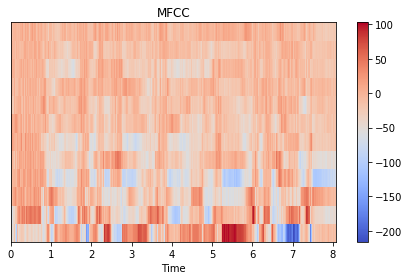

In [69]:
librosa.display.specshow(mfcc.T,x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

으악 성공 ㅠㅠ